# **Amazon Reviews Sentiment Analysis**

## **Import Libraries**

We begin by importing the necessary libraries for this sentiment analysis project. These include libraries for data manipulation, visualization, and machine learning models. Additionally, we use `spaCy` for natural language processing and `torch` for deep learning with RNN and LSTM models.

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
import seaborn as sns
from sklearn.model_selection import train_test_split
import spacy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


<Figure size 1000x500 with 0 Axes>

## **Load spaCy Model**

Next, we load the **spaCy** English language model. This model will be used for text tokenization, lemmatization, and other NLP-related tasks in the project.

In [2]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm')


## **Setup Device for GPU/CPU**

We check for GPU availability using PyTorch. If a GPU is available, it will be used for faster training; otherwise, the model will fall back to using the CPU.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cuda


## **Load Dataset**

We load the Amazon reviews dataset into a pandas DataFrame and display the first 10 rows. The dataset contains the review text along with the sentiment label for each review.

In [4]:
df = pd.read_csv('Data/amazon_reviews.csv')
df.head(10)


,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0
5,positive,overall love this mouse the size weight clicki...,68,3.0
6,neutral,it stopped working,3,1.0
7,positive,my son uses school issued chromebook for schoo...,170,1.0
8,negative,loved this cute little mouse but it broke afte...,17,1.0
9,negative,should ve spent the money to get quality produ...,17,1.0


**Check for Missing Values**

We check for missing values in the dataset to ensure that there are no missing entries that could affect our model’s performance. This step will show how many null values exist in each column.

In [5]:
print(df.isna().sum())

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64


**Drop Missing Values**

To maintain data integrity, we drop rows with missing values in the dataset. After dropping, we check again to ensure no missing values remain.

In [6]:
df = df.dropna()
print(df.isna().sum())

sentiments               0
cleaned_review           0
cleaned_review_length    0
review_score             0
dtype: int64


## **spaCy-based Text Preprocessing**

We define a text preprocessing function using **spaCy**. This function removes non-alphabetical characters, converts the text to lowercase, tokenizes the text, removes stop words and punctuation, and applies lemmatization to reduce words to their base forms. The cleaned reviews are then stored in the `cleaned_review` column.

In [7]:
# spaCy-based text preprocessing
def text_preprocessing(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetical characters
    doc = nlp(text.lower())  # Tokenize using spaCy and convert to lowercase
    
    # Remove stop words and punctuation
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    
    return ' '.join(tokens)

# Apply preprocessing
df['cleaned_review'] = df['cleaned_review'].apply(text_preprocessing)
df['cleaned_review'].head()


0            wish get early love make work laptop easy
1    ve learn lesson open package use product right...
2                            slow lag find well option
3    roller ball stop work month minimal use piece ...
4        like color size day return period hold charge
Name: cleaned_review, dtype: object

## **Tokenization Using Keras**

We use the **Keras Tokenizer** to convert the preprocessed text into sequences of tokens (integers). Each word in the cleaned reviews is assigned a unique index.

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_review'])
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])

## **Padding Sequences**

Since reviews can vary in length, we pad the tokenized sequences to ensure all sequences have the same length. We also one-hot encode the labels (sentiments) for model training.

In [9]:
max_len = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len)
labels = pd.get_dummies(df['sentiments']).values

## **Train-Validation Split**

We split the dataset into training and validation sets using an 80-20 split. This will help us evaluate model performance on unseen data.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

## **Create Tensor Datasets and Data Loaders**

The training and validation sets are converted into tensor datasets and loaded into **PyTorch DataLoaders** to enable batch processing during model training.

In [11]:
train_data = TensorDataset(torch.from_numpy(X_train).long(), torch.from_numpy(y_train).float())
val_data = TensorDataset(torch.from_numpy(X_val).long(), torch.from_numpy(y_val).float())
train_loader = DataLoader(train_data, shuffle=True, batch_size=50)
val_loader = DataLoader(val_data, shuffle=True, batch_size=50)

## **Define RNN Model**

We define a simple Recurrent Neural Network (RNN) model using **PyTorch**. The model consists of an embedding layer, an RNN layer, a dropout layer to prevent overfitting, and a fully connected layer that outputs the predictions.

In [12]:
class RNN(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(RNN, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(len(tokenizer.word_index) + 1, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x):
        embedded = self.embedding(x)
        out, hidden = self.rnn(embedded)
        out = self.dropout(out)
        out = self.fc(out[:, -1])
        return out

## **Define LSTM Model**

We define a Long Short-Term Memory (LSTM) model using **PyTorch**. This model is designed to handle longer sequences and capture long-term dependencies in the data. Like the RNN model, it has embedding, LSTM, dropout, and fully connected layers.

In [13]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size, n_layers, drop_prob=0.5):
        super(LSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out[:, -1])
        out = self.fc(lstm_out)
        return out


## **Define Accuracy Function**

We define an accuracy function to compute the accuracy of the model predictions. The function takes the model outputs and labels, and calculates the proportion of correct predictions.

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


## **Model Initialization**

Here we initialize the RNN and LSTM models. We set hyperparameters such as the number of epochs, embedding dimension, hidden layer dimension, and the number of layers for both models. We also move the models to the selected device (GPU or CPU).


In [15]:
epochs = 20
output_size = 3
embedding_dim = 400
hidden_dim = 256
n_layers = 2
vocab_size = len(tokenizer.word_index) + 1

rnn_model = RNN(output_size, embedding_dim, hidden_dim, n_layers).to(device)
lstm_model = LSTM(vocab_size, embedding_dim, hidden_dim, output_size, n_layers).to(device)

## **Model Summary**

We define a helper function to print the summary of the models. This will display the architecture and layers of both the RNN and LSTM models.

In [16]:
def print_model_summary(model, model_name):
    print(f"Model Summary for {model_name}")
    print(model)
    print("\n")

print_model_summary(rnn_model, "RNN")
print_model_summary(lstm_model, "LSTM")

Model Summary for RNN
RNN(
  (embedding): Embedding(7259, 400)
  (rnn): RNN(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


Model Summary for LSTM
LSTM(
  (embedding): Embedding(7259, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)




## **Define Optimizers and Loss Function**

We define the optimizers and the loss function for training the RNN and LSTM models. We use the Adam optimizer with a learning rate of 0.001 and CrossEntropyLoss as the loss function.


In [17]:
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()


## **Training and Validation Function**

This function handles both the training and validation processes. For each epoch, it trains the model on the training set and evaluates it on the validation set. It tracks and returns the training and validation losses as well as validation accuracy.


In [18]:
def train_and_validate(model, optimizer, criterion, train_loader, val_loader, epochs, device):
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, torch.max(labels, 1)[1])
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        total_val_loss, total_acc = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                output = model(inputs)
                val_loss = criterion(output, torch.max(labels, 1)[1])
                total_val_loss += val_loss.item()
                acc = accuracy(output, torch.max(labels, 1)[1])
                total_acc += acc.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        avg_acc = total_acc / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accs.append(avg_acc)

        print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, Val Acc: {avg_acc}')

    return train_losses, val_losses, val_accs


## **Plot Training and Validation Losses**

This function plots the training and validation losses over the epochs to help visualize model performance and check for overfitting or underfitting.

In [19]:
def plot_losses(Model_name, train_losses, val_losses, epochs):
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Losses for {Model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


## **Train RNN Model**

We begin training the RNN model by calling the `train_and_validate` function and plotting the losses for each epoch.


RNN Start Training: 

Epoch: 1/20, Train Loss: 0.6674906147255314, Val Loss: 0.5931657480342047, Val Acc: 0.7659682512283326
Epoch: 2/20, Train Loss: 0.5265973635929094, Val Loss: 0.49109324770314355, Val Acc: 0.8029841201645987
Epoch: 3/20, Train Loss: 0.45318714743681093, Val Loss: 0.5100609881537301, Val Acc: 0.7992698379925319
Epoch: 4/20, Train Loss: 0.3717113445988662, Val Loss: 0.4915888684136527, Val Acc: 0.8184761890343257
Epoch: 5/20, Train Loss: 0.3714301130540079, Val Loss: 0.5374643645116262, Val Acc: 0.798888885974884
Epoch: 6/20, Train Loss: 0.25888301268648756, Val Loss: 0.4389736777969769, Val Acc: 0.8496190454278674
Epoch: 7/20, Train Loss: 0.20310827860568495, Val Loss: 0.45130846734557833, Val Acc: 0.8571111040455954
Epoch: 8/20, Train Loss: 0.16507670263217078, Val Loss: 0.4930744435106005, Val Acc: 0.8675555510180337
Epoch: 9/20, Train Loss: 0.13567694431680033, Val Loss: 0.5439091901694025, Val Acc: 0.8576190437589373
Epoch: 10/20, Train Loss: 0.1341790175467408,

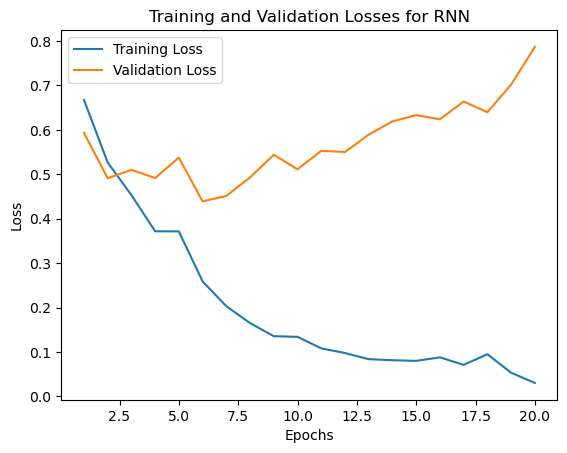

In [20]:
print("RNN Start Training: \n")
rnn_train_losses, rnn_val_losses, rnn_val_accs = train_and_validate(rnn_model, rnn_optimizer, criterion, train_loader, val_loader, epochs, device)
plot_losses("RNN", rnn_train_losses, rnn_val_losses, epochs)

## **Train LSTM Model**

Similarly, we train the LSTM model and plot the losses across epochs for both training and validation sets.

LSTM Start Training: 

Epoch: 1/20, Train Loss: 0.5543129785026578, Val Loss: 0.4148785957268306, Val Acc: 0.8335555476801736
Epoch: 2/20, Train Loss: 0.3447224205668024, Val Loss: 0.36806384112153734, Val Acc: 0.862349202803203
Epoch: 3/20, Train Loss: 0.22387321494358906, Val Loss: 0.35104322284460066, Val Acc: 0.8812063472611563
Epoch: 4/20, Train Loss: 0.1427735599133072, Val Loss: 0.38053924622280255, Val Acc: 0.8817777752876281
Epoch: 5/20, Train Loss: 0.0963259484324095, Val Loss: 0.45315161219664984, Val Acc: 0.8838412633963993
Epoch: 6/20, Train Loss: 0.07467796858199102, Val Loss: 0.43788980644728454, Val Acc: 0.8923492022923061
Epoch: 7/20, Train Loss: 0.062490340323093606, Val Loss: 0.4585233573402677, Val Acc: 0.8872698400701795
Epoch: 8/20, Train Loss: 0.04995875566588085, Val Loss: 0.4973904646666987, Val Acc: 0.895999995299748
Epoch: 9/20, Train Loss: 0.034380573774738195, Val Loss: 0.5270593882405332, Val Acc: 0.894126980645316
Epoch: 10/20, Train Loss: 0.0294222620130

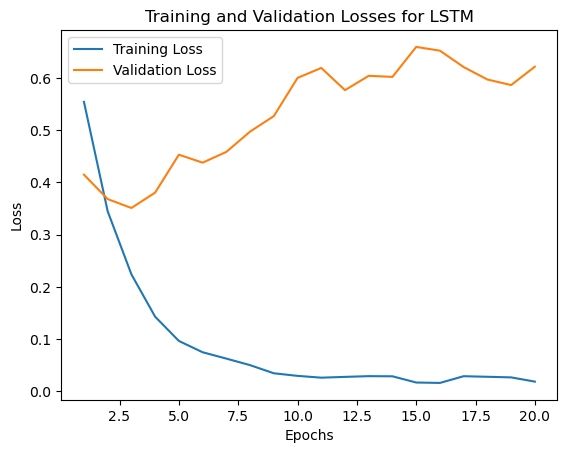

In [21]:
print("LSTM Start Training: \n")
lstm_train_losses, lstm_val_losses, lstm_val_accs = train_and_validate(lstm_model, lstm_optimizer, criterion, train_loader, val_loader, epochs, device)
plot_losses("LSTM", lstm_train_losses, lstm_val_losses, epochs)

## **Build GUI for Sentiment Prediction**

We build a simple GUI using **tkinter** for sentiment prediction. The user can enter a review, choose between the RNN or LSTM model, and the predicted sentiment will be displayed.

In [28]:
import tkinter as tk
from tkinter import messagebox
import torch

# Assuming your models and tokenization are already set up

# Example predict_sentiment function (modify as per your actual model and preprocessing)
def predict_sentiment(model, review, tokenizer, max_len, device):
    review_cleaned = text_preprocessing(review)  # Assuming text_preprocessing is defined
    sequence = tokenizer.texts_to_sequences([review_cleaned])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    input_tensor = torch.from_numpy(padded_sequence).long().to(device)
    model.eval()
    with torch.no_grad():
        prediction = model(input_tensor)
        predicted_index = torch.argmax(prediction, dim=1).item()
    sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    return sentiment_map[predicted_index]

# Action triggered when the "Predict Sentiment" button is clicked
def on_predict():
    review = text_entry.get("1.0", "end-1c")  # Get the input text from the Text widget
    if review.strip() == "":
        messagebox.showinfo("Prediction", "Please enter a review for prediction.")
    else:
        selected_model = model_var.get()  # Get selected model (RNN or LSTM)
        if selected_model == 'RNN':
            model_to_use = rnn_model  # Ensure rnn_model is defined
        elif selected_model == 'LSTM':
            model_to_use = lstm_model  # Ensure lstm_model is defined
        predicted_sentiment = predict_sentiment(model_to_use, review, tokenizer, max_len, device)
        messagebox.showinfo("Prediction", f"The predicted sentiment of the review is: {predicted_sentiment}")

# GUI setup
root = tk.Tk()
root.title("Sentiment Analysis of Reviews")

# Add a Text box to enter reviews
text_entry = tk.Text(root, height=10, width=50)
text_entry.pack(padx=10, pady=10)

# Add model selection radio buttons
model_var = tk.StringVar(value='LSTM')  # Default model selection is LSTM 
rnn_button = tk.Radiobutton(root, text="RNN", variable=model_var, value='RNN')
lstm_button = tk.Radiobutton(root, text="LSTM", variable=model_var, value='LSTM')

rnn_button.pack()
lstm_button.pack()

# Add prediction button
predict_button = tk.Button(root, text="Predict Sentiment", command=on_predict)
predict_button.pack(pady=10)

# Run the GUI
root.mainloop() 
